# Exercise: PyTorch training loop
Implement a clean PyTorch training loop for the CIFAR-10 dataset, including data loading and preprocessing, defining model options, implementing training and evaluation functions, training and evaluating a selected model, and summarizing the results.

## Load and preprocess CIFAR-10 data

* Define transformations for training and test datasets including data augmentation and normalization.
* Load the CIFAR-10 datasets with these transformations.
* Create data loaders for both training and testing.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Transformations for the training set
transform_train = transforms.Compose([
    # Create a 4-pixel 0-filled border and randomly crop out a 32 x 32 patch
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # Changes shape from (height, width, channels) to (channels, height, width).
    transforms.ToTensor(),
    # mean-std colour channel normalization; classic CIFAR-10 values
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Transformations for the test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create DataLoaders for use in training and testing
batch_size = 128
num_workers = 2  # Parallelize data loading

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of test samples: {len(test_set)}")

Number of training samples: 50000
Number of test samples: 10000


## Define a CNN model for image classification

In [2]:
import torch.nn as nn


# Define a simple Convolutional Neural Network (CNN) model class
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(

            # Convolutional layer
            # input: 3 channels x height x width -> output: 32 features x height x width
            # parameter count: (3 channels x (3 x 3) kernel + 1 bias) x 32 features = 896
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            
            nn.ReLU(),

            # Normalize each feature separately (compute mean and std. dev. across the whole data batch), then apply location-scale transformation
            # input: 32 features x height x width -> output: 32 features x height x width
            # parameter count: (1 location + 1 scale) x 32 features = 64
            nn.BatchNorm2d(32),

            # input: 32 features x height x width -> output: 64 features x height x width
            # parameter count: (32 features x (3 x 3) kernel + 1 bias) x 64 features = 18,496
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            
            nn.ReLU(),
            
            # input: 64 features x height x width -> output: 64 features x height x width
            # parameter count: (1 location + 1 scale) x 64 features = 128
            nn.BatchNorm2d(64),

            # Downsample feature maps by taking the maximum value in non-overlapping 2×2 regions (reduces later compute; adds small translation tolerance; keeps strong features like corners and drops noise)
            # input: 64 features x height x width -> output: 64 features x (height/2) x (width/2)
            # parameter count: 0
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(

            # Dropout regularization
            # During training, every activation has a 25% chance of being set to zero. The remaining 75% are scaled up by 1 / (1 − 0.25).
            # During testing, no activations are set to zero.
            nn.Dropout(0.25),

            # Fully connected linear layer
            # input: 64 features x (height/2) x (width/2) -> output: 512 activations
            # parameter count: 64 x (height/2) x (width/2) x 512 = = 8,388,608
            nn.Linear(64 * 16 * 16, 512),
            
            nn.ReLU(),

            # Normalize each activation separately across a batch: stabilizes feature distributions; allows higher learning rates; often improves generalization
            # input: 512 activations -> output: 512 activations
            # parameter count: (1 location + 1 scale) x 512 activations = 1,024
            nn.BatchNorm1d(512),
            
            nn.Dropout(0.5),
            
            # Fully connected linear layer
            # input: 512 activations -> output: 10 activations
            # parameter count: 512 x 10 = 5,120
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc_layers(x)
        return x

## Define training loop

In [3]:
def train_one_epoch(model, train_loader, loss_function, optimizer, device):
    '''
    Handle a single training pass, including forward and backward propagation,
    loss calculation, gradient optimization, and accumulation of training metrics.
    '''
    # Set the model to training mode
    model.train()
    # Initialize metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in train_loader:
        # Load data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    # Return average metrics
    epoch_loss = running_loss / total_samples
    epoch_accuracy = 100 * correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

In [4]:
def evaluate_model(model, data_loader, loss_function, device):
    '''
    Place the model in evaluation mode, disable gradient calculations,
    and compute average loss and accuracy on a given dataset.
    '''
    model.eval()  # Set the model to evaluation mode

    # Init metrics
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient calculations, i.e. freeze the model parameters
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [5]:
def train_model(model, train_loader, validation_loader, loss_function, optimizer, num_epochs, device):
    '''
    Orchestrate model training over multiple epochs, calling `train_one_epoch`
    and `evaluate_model` to track both training and validation performance.
    '''
    print("Starting training...")
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'validation_loss': [],
        'validation_accuracy': []
    }
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_function, optimizer, device)
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, loss_function, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['validation_loss'].append(validation_loss)
        history['validation_accuracy'].append(validation_accuracy)
        print(f"Completed epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

    print("Training finished.")
    return history

## Train and evaluate the model

**Reasoning**:
I need to define the loss function and optimizer, set the number of epochs, call the `train_model` function to start training, and then evaluate the model's performance on the test set using the `evaluate_model` function, finally printing the results.



**Reasoning**:
The subtask requires including a plot to visualize training and validation accuracy/loss over epochs. To achieve this, I need to modify the `train_model` function to store and return the loss and accuracy for each epoch. Then, I will re-run the training process with the updated function and use the collected history to generate the plot.



In [6]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Determine the available device (GPU if available, otherwise CPU) and
# move the model to the chosen device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = SimpleCNN()
model.to(device)
print(f"Model moved to device: {device}")

# Choose the loss function: cross-entropy loss for classification task
loss_function = nn.CrossEntropyLoss()

# Choose the optimizer, for example `Adam` or `SGD` with appropriate learning rate.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
num_epochs = 20
training_history = train_model(model, train_loader, test_loader, loss_function, optimizer, num_epochs, device)

# Test
final_test_loss, final_test_accuracy = evaluate_model(model, test_loader, loss_function, device)

print(f"\nFinal Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Model moved to device: cpu
Starting training...
Completed epoch 1/20: Train Loss: 1.4897, Train Accuracy: 46.71%, Validation Loss: 1.3856, Validation Accuracy: 59.79%
Completed epoch 2/20: Train Loss: 1.1883, Train Accuracy: 57.50%, Validation Loss: 1.0179, Validation Accuracy: 64.54%
Completed epoch 3/20: Train Loss: 1.0669, Train Accuracy: 62.12%, Validation Loss: 1.0582, Validation Accuracy: 68.57%
Completed epoch 4/20: Train Loss: 1.0029, Train Accuracy: 64.52%, Validation Loss: 0.8330, Validation Accuracy: 70.71%
Completed epoch 5/20: Train Loss: 0.9504, Train Accuracy: 66.44%, Validation Loss: 0.7908, Validation Accuracy: 72.87%
Completed epoch 6/20: Train Loss: 0.9097, Train Accuracy: 68.18%, Validation Loss: 0.8434, Validation Accuracy: 73.91%
Completed epoch 7/20: Train Loss: 0.8748, Train Accuracy: 69.35%, Validation Loss: 0.7838, Validation Accuracy: 73.66%
Completed epoch 8/20: Train Loss: 0.8592, Train Accuracy: 69.81%, Validation Loss: 0.7125, Validation Accuracy: 75.23%


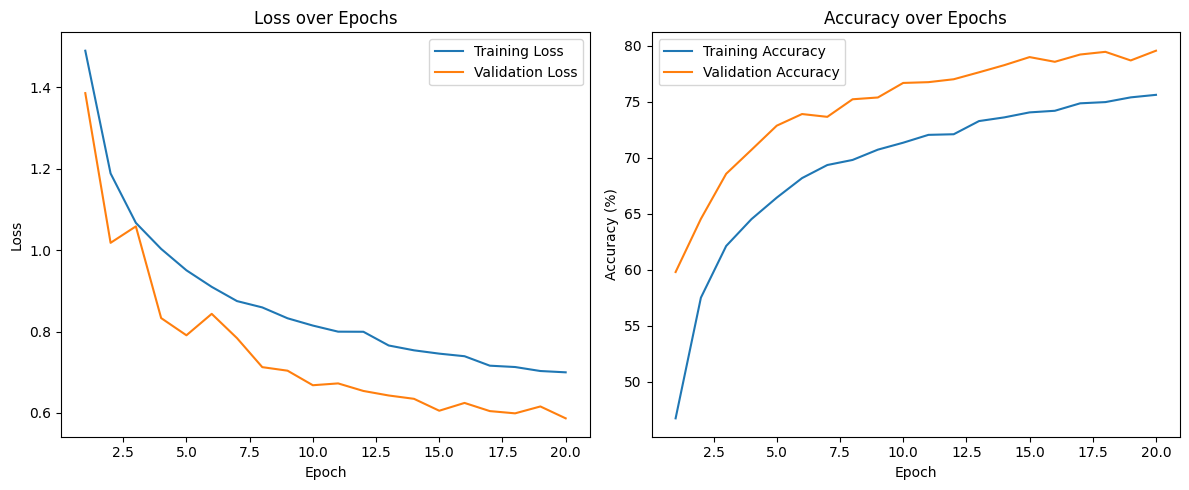

In [7]:
# Plot the training history
plt.figure(figsize=(12, 5))

plot_epochs = list(range(1, len(training_history['train_loss']) + 1))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(plot_epochs, training_history['train_loss'], label='Training Loss')
plt.plot(plot_epochs, training_history['validation_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(plot_epochs, training_history['train_accuracy'], label='Training Accuracy')
plt.plot(plot_epochs, training_history['validation_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()